# Imports

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/Users/imad/anaconda3/envs/dl/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%load_ext lab_black

# Data

In [3]:
with open("../data/names.txt", "r") as f:
    words = f.read().splitlines()

In [4]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
len(words), min(len(w) for w in words), max(len(w) for w in words)

(32033, 2, 15)

(array([6.4000e+02, 2.9830e+03, 7.1330e+03, 1.6476e+04, 3.1080e+03,
        1.1180e+03, 5.0800e+02, 2.9000e+01, 3.0000e+01, 8.0000e+00]),
 array([ 2. ,  3.3,  4.6,  5.9,  7.2,  8.5,  9.8, 11.1, 12.4, 13.7, 15. ]),
 <BarContainer object of 10 artists>)

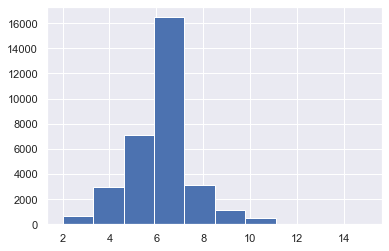

In [6]:
plt.hist([len(word) for word in words])

# Bigram Model

In [7]:
# Create bigram data with special tokons for start and end of the word
b = {}
for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [8]:
sorted(b.items(), key=lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [9]:
# Build vocab
chars = sorted(list(set("".join(words))))
stoi = {s: i for i, s in enumerate(chars, 1)}
# Special token for both start and end of word
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
num_classes = len(stoi)

In [10]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [18]:
N = torch.zeros((num_classes, num_classes), dtype=torch.int32)

In [19]:
for w in words:
    # Append and prepend special token for start and end of word
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

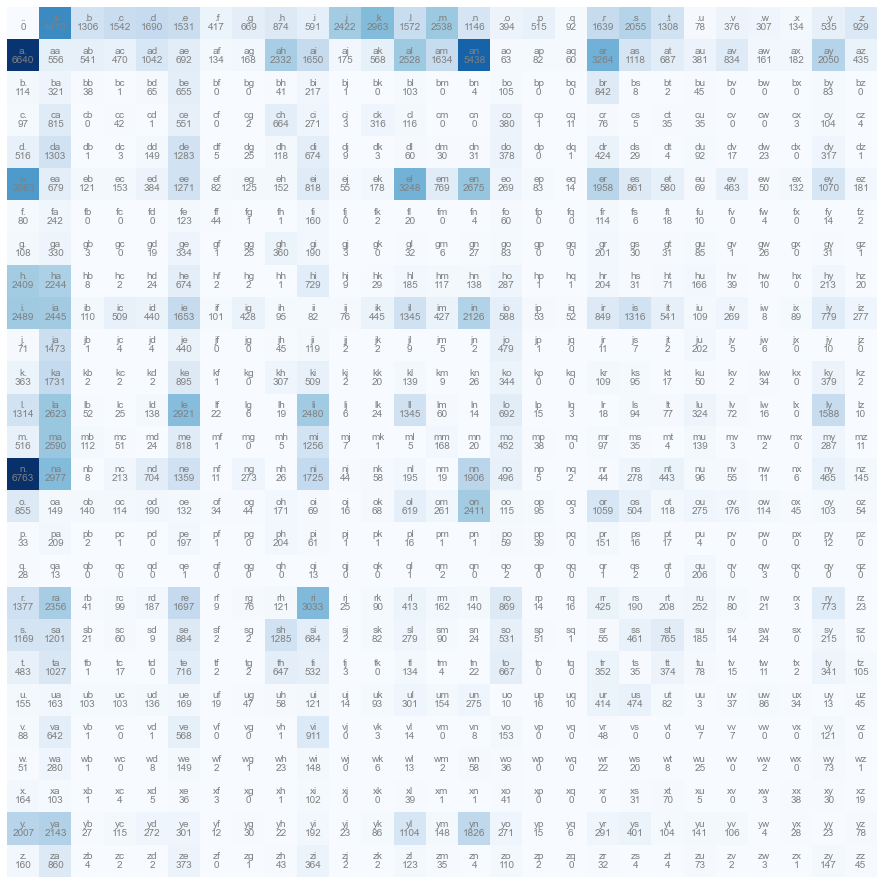

In [20]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")

In [21]:
# Get the probability for all the characters to be the first character
p = N[0].float()
p = p / p.sum()
p, p.argmax()

(tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
         0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
         0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290]),
 tensor(1))

In [22]:
# Model smooting in the case the next letter is not followed by
# any letter from the training data
P = (N + 1).float()
P /= P.sum(1, keepdims=True)

In [23]:
# Generator object for reproducability
SEED = 2147483647
g = torch.Generator().manual_seed(SEED)

# Generate 5 names
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])

        # exit while loop once we see special character
        if ix == 0:
            break
    print("".join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


In [24]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [25]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
# Training loss
print(f"{nll/n}")

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


In [26]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:  # One word as a running example
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [27]:
xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [28]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g)

xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
logits = xenc @ W  # predict log-counts
counts = logits.exp()  # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character

In [29]:
# probability distribution for the current word
probs.shape

torch.Size([5, 27])

In [30]:
seq_len = len(ys)
nlls = torch.zeros(seq_len)
for i in range(seq_len):
    # i-th bigram:
    x = xs[i].item()  # input character index
    y = ys[i].item()  # label character index
    print("--------")
    print(f"bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})")
    print("input to the neural net:", x)
    print("output probabilities from the neural net:", probs[i])
    print("label (actual next character):", y)
    p = probs[i, y]
    print("probability assigned by the net to the the correct character:", p.item())
    logp = torch.log(p)
    print("log likelihood:", logp.item())
    nll = -logp
    print("negative log likelihood:", nll.item())
    nlls[i] = nll

print("=========")
print("average negative log likelihood, i.e. loss =", nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286253273487091
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

The above bigram model is basically a lookup into the bigram count matrix and pick the next character with the highest probability given the previous character. Therefore, the previois character index is used to get the row in the count matrix and then the column with the highest probability will be picked as the next character.

# Simple Fully Connected (1 linear layer) NN

In [31]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, num_classes), generator=g, requires_grad=True)

The output of the network can be thought of as the log-count (logit) of the bigram count matrix.

One-hot encoding is also just a lookup from the weight matrix.

In [32]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
logits = xenc @ W  # predict log-counts
counts = logits.exp()  # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [33]:
print(loss.item())

3.7693049907684326


In [34]:
# backward pass
W.grad = None  # set to zero the gradient
loss.backward()

In [35]:
W.data += -0.1 * W.grad

In [36]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

number of examples:  228146


In [39]:
# initialize the 'network'
g = torch.Generator().manual_seed(SEED)
W = torch.randn((num_classes, num_classes), generator=g, requires_grad=True)

In [40]:
# gradient descent
for k in range(100):
    # forward pass
    xenc = F.one_hot(
        xs, num_classes=num_classes
    ).float()  # input to the network: one-hot encoding
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean()
    # loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
    if k % 10 == 0:
        print(loss.item())

    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

3.758953332901001
2.6890029907226562
2.572789192199707
2.5301806926727295
2.5086867809295654
2.496137857437134
2.488049268722534
2.482424259185791
2.478290557861328
2.475132703781128


We're approaching the same loss as the bigram model since we are basically doing the same thing. The only difference is that gradient descent is much more flexible and let us do much more complicated things later with different architectures and optimization setups.

Weight decay in this setting is the same as smoothing in the bigram model. The larger the regularizer magnitude, it forces the weights to be closer to zero which means pushes the weight to be more equal and end up with more uniform distribution. This is exactly what happended when we increase the smoothing facttor from 1 -> 100 -> 1000 ...

In [41]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(SEED)

for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=num_classes).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True)  # probabilities for next character
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

mor.
axwaninaymoryles.
kondmaisah.
anchshizarie.
odaren.
